# White Box Lie Detection Experiment

This notebook implements the White Box approach for lie detection using internal model activations.
It follows the plan from `Black_vs_White_Lie_Detection/Documentation/Plan.md`.

In [1]:
!git clone https://github.com/GeorgeVasile04/llm_lie_detection_black_vs_white_box.git

Cloning into 'llm_lie_detection_black_vs_white_box'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 412 (delta 0), reused 2 (delta 0), pack-reused 403 (from 1)
Receiving objects: 100% (412/412), 46.60 MiB | 8.44 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Updating files: 100% (368/368), done.


In [2]:
# Setup and Imports
import sys
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- Environment Detection ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Mount Google Drive so model weights are cached there across sessions
    from google.colab import drive
    drive.mount("/content/drive")

    # HuggingFace will download/cache models here instead of the ephemeral /root/.cache
    HF_CACHE_DIR = "/content/drive/MyDrive/hf_cache"
    os.makedirs(HF_CACHE_DIR, exist_ok=True)
    os.environ["HF_HOME"] = HF_CACHE_DIR
    print(f"HuggingFace cache set to: {HF_CACHE_DIR}")

    # Install required packages (ipython upgrade needed for Python 3.12 compatibility)
    subprocess.run([
        "pip", "install", "-q", "--upgrade",
        "ipython",
        "transformers", "accelerate", "huggingface_hub",
        "scikit-learn", "joblib", "tqdm", "jaxtyping", "pyparsing",
    ], check=True)

    # Assuming the repository is already cloned and we are inside it or it's in the path
    # If running directly from the cloned repo in Colab, add the current directory to path
    if os.getcwd() not in sys.path:
        sys.path.append(os.getcwd())

    # Add repo root so 'White_Box_Lie_Detection' package is importable
    # Adjust this path depending on where you cloned the repo in Colab
    # For example, if cloned to /content/llm_lie_detection_black_vs_white_box
    REPO_DIR = "/content/llm_lie_detection_black_vs_white_box"
    if os.path.exists(REPO_DIR):
        if REPO_DIR not in sys.path:
            sys.path.insert(0, REPO_DIR)

        # Add the White_Box folder so 'white_box_utils' is importable
        WB_DIR = os.path.join(REPO_DIR, "Black_vs_White_Lie_Detection", "White_Box")
        if WB_DIR not in sys.path:
            sys.path.insert(0, WB_DIR)

else:
    # Local: add the llm-lie-detection root so White_Box_Lie_Detection package is found
    # Assuming this notebook is in Black_vs_White_Lie_Detection/White_Box
    llm_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    if llm_root not in sys.path:
        sys.path.append(llm_root)

# Try importing to ensure it works
try:
    import white_box_utils
except ImportError:
    # Fallback: try to find the utils if the paths above were slightly off
    sys.path.append(os.getcwd())
    try:
        import white_box_utils
    except ImportError:
        print("Warning: white_box_utils not found. Please check your path setup.")

%load_ext autoreload
%autoreload 2

Mounted at /content/drive
HuggingFace cache set to: /content/drive/MyDrive/hf_cache


In [3]:
# Authenticate with Hugging Face
# You need to accept the license at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf first!
from huggingface_hub import login

# specific_token = "hf_..." # Replace with your token if you don't want to paste it every time
# login(token=specific_token)

# Or simply login interactively:
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Step 1: Load the Dataset
We load the common dataset prepared for the comparison. It should contain pairs of True/False statements.

In [4]:
# Define path to the dataset
if IN_COLAB:
    DATASET_PATH = os.path.join(REPO_DIR, "Black_vs_White_Lie_Detection", "Data", "common_sens_qa_v2.json")
else:
    DATASET_PATH = os.path.join(os.path.dirname(os.getcwd()), "Data", "common_sens_qa_v2.json")

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

# Load raw data
raw_df = white_box_utils.load_dataset(DATASET_PATH)
print(f"Loaded raw dataset with {len(raw_df)} samples.")

# Process into Truth/Lie pairs
# LIMITING TO 50 SAMPLES FOR TESTING
df = white_box_utils.generate_pairs_from_raw_data(raw_df, num_samples=50)
print(f"Generated {len(df)} paired samples (Truth + Lie).")
df.head()


Loaded raw dataset with 2541 samples.
Generated 100 paired samples (Truth + Lie).


,question,answer,label
0,A medium can really speak with the dead. Is th...,True,1
1,A busboy clears the tables before another cust...,False,1
2,"You can play the 2016 video game, The Witness ...",True,0
3,Part of the Notre Dame was destroyed with the ...,True,1
4,Part of the Notre Dame was destroyed with the ...,False,0


## Step 2: Load the Model
We load the LLM (e.g., Llama-2-7b-chat-hf) using the `repeng` library utilities.
Note: This requires a GPU.

In [6]:
MODEL_ID = "Llama-2-7b-chat-hf"
# MODEL_ID = "pythia-1b" # A smaller model for testing - replace with Llama-2-7b-chat-hf once license is accepted

try:
    llm = white_box_utils.load_model(MODEL_ID)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Ensure you have a GPU available and the model weights downloaded.")

Loading model Llama-2-7b-chat-hf on cuda (half_precision=True)...
Loading LLM Llama-2-7b-chat-hf


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [7]:
# --- Fix for 'Expected tuple, instead found: torch.Tensor' Error ---
# The repeng library expects model layers to output tuples, but newer transformers versions
# or specific configurations might return a single Tensor. We patch it here.

import White_Box_Lie_Detection.repeng.hooks.points as points_module
import torch
from typing import Any

def patched_extract(self, output: Any) -> torch.Tensor:
    # If output is already a tensor (and we want index 0), just return it
    if isinstance(output, torch.Tensor):
        if self.index == 0:
            return output
        raise ValueError(f"Expected tuple for index {self.index}, but got tensor.")

    # Original logic
    if not isinstance(output, tuple):
         raise TypeError(f"Expected tuple or tensor, instead found: {type(output)}")

    return output[self.index]

# Apply the patch to the class method
points_module.TupleTensorExtractor.extract = patched_extract
print("Successfully patched TupleTensorExtractor to handle Tensor outputs.")

Successfully patched TupleTensorExtractor to handle Tensor outputs.


## Step 3: Extract Activations
We pass the data through the model and extract the hidden states at the last token.

In [8]:
# This returns a dictionary: {layer_name: (X, y)}
layer_activations = white_box_utils.extract_activations(llm, df)

# Check shape of one layer
first_layer = list(layer_activations.keys())[0]
X_example, y_example = layer_activations[first_layer]
print(f"Layer: {first_layer}, X shape: {X_example.shape}, y shape: {y_example.shape}")

Extracting activations for 100 samples...


Extraction Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Layer: h0, X shape: (100, 4096), y shape: (100,)


--- Snapshot of internal activations from Layer: h0 ---


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Sample,Label,Dim_0,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,Dim_7,Dim_8,Dim_9
0,0,Lie (1),0.001556,0.019043,0.064453,-0.010376,-0.065430,-0.060547,-0.020508,-0.013977,0.029785,-0.056885
1,1,Lie (1),0.021118,0.001282,-0.018433,-0.053955,-0.061523,-0.038330,0.014099,0.001617,0.017578,-0.051758
2,2,Truth (0),-0.002869,0.020142,0.066895,-0.002960,-0.054199,-0.058105,-0.015503,-0.003082,0.033936,-0.052490
3,3,Lie (1),0.001083,0.020264,0.061523,-0.010986,-0.065430,-0.061035,-0.018066,-0.017090,0.030273,-0.056641
4,4,Truth (0),0.019531,0.001923,-0.023682,-0.056641,-0.067871,-0.037842,0.018677,-0.001511,0.020996,-0.047852


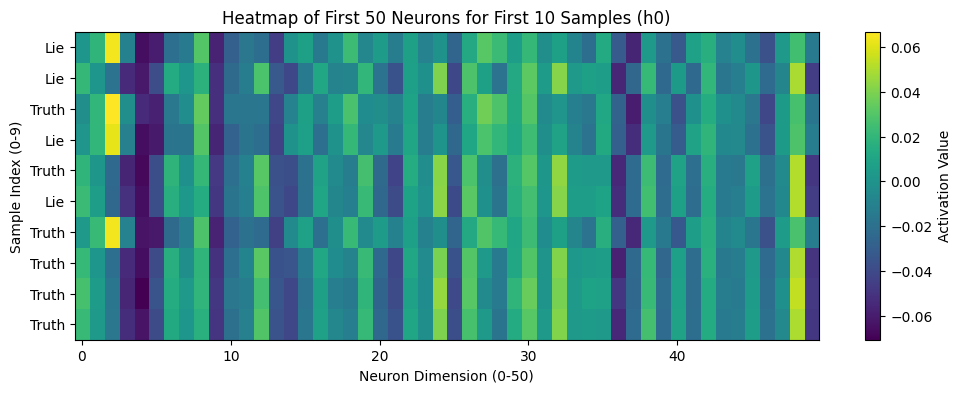

In [9]:
# Visualization of extracted activations
# Let's inspect the activations for the first layer (or any layer you choose)
layer_to_inspect = list(layer_activations.keys())[0]  # First layer
X_vis, y_vis = layer_activations[layer_to_inspect]

# Create a readable DataFrame for a few samples
# showing Label and first 10 activations (out of 2048+)
vis_data = []
for i in range(min(5, len(X_vis))):  # Show first 5 samples
    row = {
        "Sample": i,
        "Label": "Lie (1)" if y_vis[i] == 1 else "Truth (0)",
    }
    # Add first 10 dimensions of the vector
    for dim in range(10):
        row[f"Dim_{dim}"] = X_vis[i, dim]
    vis_data.append(row)

vis_df = pd.DataFrame(vis_data)
print(f"--- Snapshot of internal activations from Layer: {layer_to_inspect} ---")
display(vis_df)

# Visualizing as a Heatmap
plt.figure(figsize=(12, 4))
# Normalize for better visualization color range
X_subset = X_vis[:10, :50] # 10 samples, first 50 dimensions
plt.imshow(X_subset, aspect='auto', cmap='viridis')
plt.colorbar(label='Activation Value')
plt.title(f"Heatmap of First 50 Neurons for First 10 Samples ({layer_to_inspect})")
plt.xlabel("Neuron Dimension (0-50)")
plt.ylabel("Sample Index (0-9)")
plt.yticks(range(10), labels=["Lie" if y == 1 else "Truth" for y in y_vis[:10]])
plt.show()

## Step 4: Train Probes
We train a Difference in Means probe on the extracted activations for each layer.

In [10]:
results = {}

print(f"Training DiM probes on {len(layer_activations)} layers...")

for layer_name, (X, y) in tqdm(layer_activations.items(), desc="Training Probes"):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train DiM probe (Difference in Means)
    # This uses the specific repeng library methodology with geometric thresholding
    result = white_box_utils.train_dim_probe_utils(X_train, y_train, X_test, y_test)
    results[layer_name] = result

Training DiM probes on 32 layers...


Training Probes:   0%|          | 0/32 [00:00<?, ?it/s]

## Step 5: Results and Analysis
Visualize the performance of the probes across different layers.

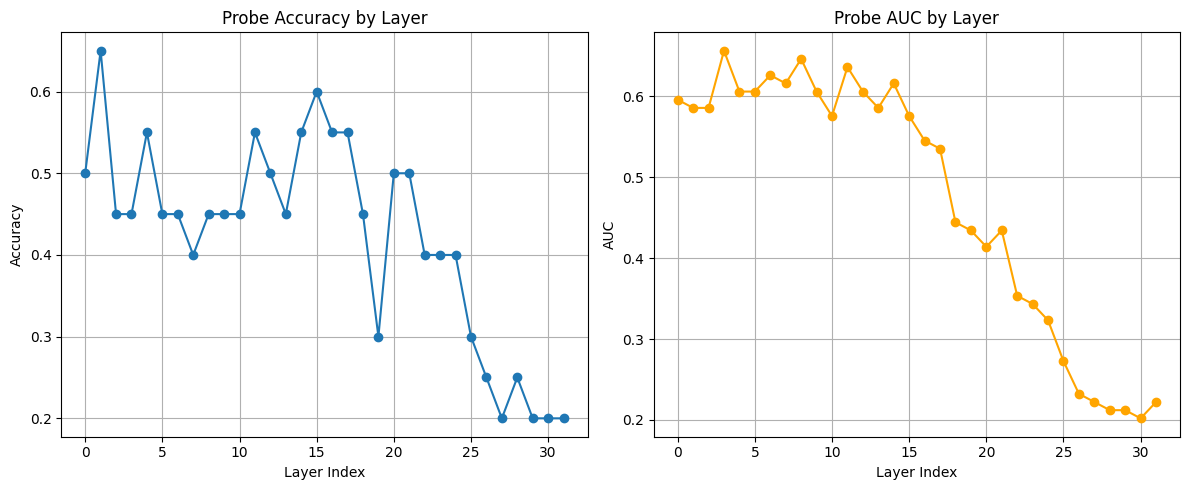


Saving results...
Metrics saved to results/Llama-2-7b-chat-hf_metrics.csv
Best probe (Layer h1, Acc 0.6500) saved to results/Llama-2-7b-chat-hf_best_probe_h1.pkl
Best Layer: h1
Best Accuracy: 0.6500
Best AUC: 0.5859


In [11]:
layers = list(results.keys())
accuracies = [results[l]['accuracy'] for l in layers]
aucs = [results[l]['auc'] for l in layers]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(accuracies, marker='o')
plt.title("Probe Accuracy by Layer")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(aucs, marker='o', color='orange')
plt.title("Probe AUC by Layer")
plt.xlabel("Layer Index")
plt.ylabel("AUC")
plt.grid(True)

plt.tight_layout()
plt.show()

# Save results to disk
print("\nSaving results...")
white_box_utils.save_results(results, output_dir="results", model_name=MODEL_ID)

# Find best layer
best_layer_idx = np.argmax(accuracies)
best_layer = layers[best_layer_idx]
print(f"Best Layer: {best_layer}")
print(f"Best Accuracy: {accuracies[best_layer_idx]:.4f}")
print(f"Best AUC: {aucs[best_layer_idx]:.4f}")